In [1]:
from simulation import *
from plot import *

# **Long-term statistics of pulsar glitches**

**Pulsars** are highly magnetized, rotating neutron stars (stellar remnants) that spin at remarkable speeds, typically hundreds of times per second. Throughout their lifetime, pulsars gradually slow down, but occasionally experience sudden bursts of increased rotation. These events, known as **glitches**, cause brief but significant jumps in the pulsar's spin rate. What makes glitches particularly interesting is their immediate onset followed by a gradual return to the previous slowdown rate, providing scientists with valuable insights into the internal workings of these dense stellar objects.

The underlying physical mechanism responsible for glitches remains an active area of theoretical investigation. Two predominant hypotheses suggest that glitches arise from either: 

- the abrupt unpinning of superfluid vortices within the neutron star's interior
- structural failures within the crustal region. 

Both proposed mechanisms result in the release of stored angular momentum, manifesting as the observed rotational acceleration of the pulsar.

The objective of this investigation is to reproduce the *microphysics-agnostic meta-model* of glitch dynamics as presented by *Carlin & Melatos (2020)*. In this framework, the globally averaged internal stress in a pulsar accumulates stochastically as a **Brownian process** between glitch events, with a glitch triggered when the stress exceeds a ***critical threshold***. This approach allows us to characterize the fundamental statistical properties of glitches without relying on specific microphysical assumptions.


### **Equation of motion**

We define $X$ to be a stochastic variable equal to the globally averaged stress in the system. In the superfluid vortex avalanche picture, $X$ is proportional to the lag between the angular speed of the rigid crust and the superfluid interior. In the crustquake picture, $X$ is proportional to the elastic strain in the crust.

Between glitches, we propose that $X(t)$ evolves according to a Wiener process, which obeys the Langevin (Itô) equation:

$$
\begin{align}
\frac{dX(t)}{dt} = \xi + \sigma B(t), \qquad (1)
\end{align}
$$

with drift coefficient $\xi$ (units: stress/time) and diffusion coefficient $\sigma$ (units: stress/$\sqrt{\mathrm{time}}$), and where $B(t)$ is a white noise process of zero mean and unit variance.

We assume both $\xi$ and $\sigma$ are constant with time. Practically, at each time-step, the stress increments by $\xi$ and undergoes a random step (up or down) by $\sigma$ multiplied by a random number drawn from a Gaussian with zero mean and variance equal to the time-step.

Equation (1) leads to the Fokker-Planck equation:

$$
\begin{align}
\frac{\partial p}{\partial t} = -\xi \frac{\partial p}{\partial X} + \frac{\sigma^2}{2} \frac{\partial^2 p}{\partial X^2} \tag{2}
\end{align}
$$

where $p\,dX = p(X, t \mid X_0)\,dX$ is the probability of finding the stress in the region $(X, X + dX)$ at time $t$, given that it started at $X = X_0$ after a glitch at $t = 0$.

The initial condition is:

$$
\begin{align}
p(X, t = 0 \mid X_0) = \delta(X - X_0) \tag{3}
\end{align}
$$

The Brownian process terminates at $X = X_c$, where $X_c$ is the stress threshold at which a glitch is triggered. This is modeled as an absorbing boundary:

$$
\begin{align}
p(X = X_c, t \mid X_0) = 0 \tag{4}
\end{align}
$$

We also require $X(t) \geq 0$ (the stress is never negative), which is implemented as a reflecting boundary at $X = 0$:

$$
\begin{align}
\left. \frac{\partial p(X, t \mid X_0)}{\partial X} \right|_{X=0} = -\frac{2\xi}{\sigma^2} p(X = 0, t \mid X_0) \tag{5}
\end{align}
$$

Equations (2)--(5) can be solved analytically under the assumption that $p(X, t \mid X_0)$ is separable in $X$ and $t$, here it is not reported for brevity.
 
The key parameter controlling the dynamics is the ratio $\xi X_c / \sigma^2$:
- For high values of $\xi X_c / \sigma^2$, drift dominates over diffusion, and the stress $X$ accumulates steadily with small random excursions.
- For low values of $\xi X_c / \sigma^2$, diffusion dominates, and $X$ exhibits large, rapid fluctuations both up and down.

#### **Simulation**

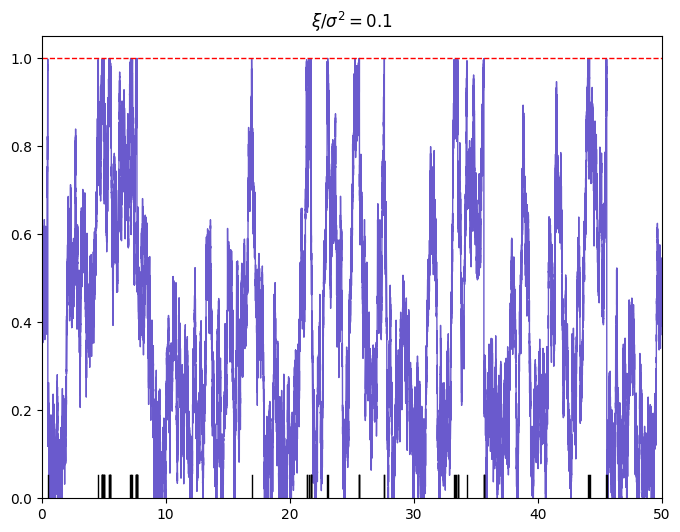

In [2]:
plot_single_trajectory(mu = 0.1,
                       xi = 0.025,
                       Xc = 1.0,
                       dist_type='neg_powerlaw',
                       dist_params={'delta':1.5,'beta':1e-2},
                       x0=0.5, T=50, N=500_000)

Let's simulate and compare theoretical and empirical results: the following function reproduces the **Fig. 1** of the paper, where are shown simulated stress trajectories and glitch events for different values of $\xi/\sigma^2$.

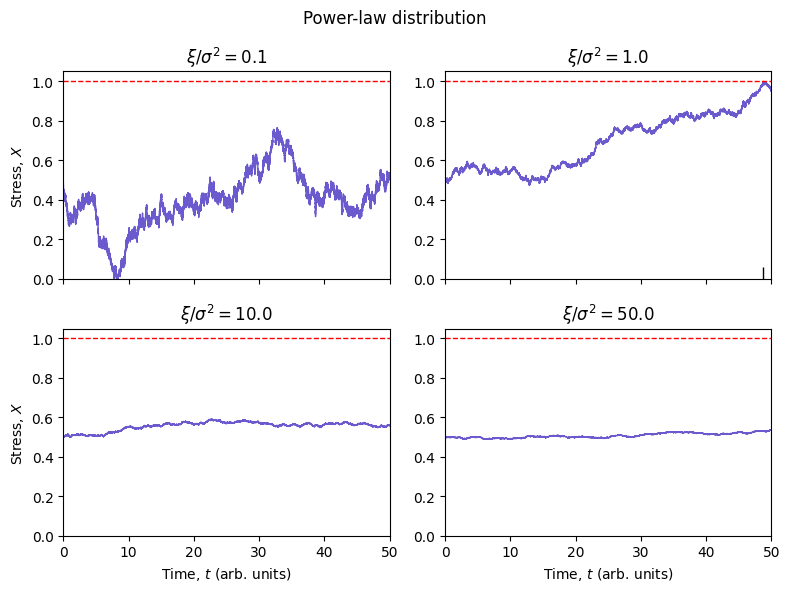

In [3]:
plot_brownian_glitch_panels(mu_list = [0.1, 1.0, 10.0, 50.0], 
                            # xi = 0.025,
                            sigma = 0.08,
                            Xc = 1.0, 
                            dist_type='neg_powerlaw', 
                            dist_params={'delta':1.5,'beta':1e-2},
                            x0=0.5, T=50, N=100_000,
                            title = 'Power-law distribution')

As we can see, these results well reproduces the one obtained by *Carlin & Melatos*:
- For low $\xi/\sigma^2$, the process exhibits **large, rapid fluctuations** in both directions, and glitches occur irregularly amid these excursions.
- In contrast, for high $\xi/\sigma^2$, drift dominates: the stress accumulates steadily with only **small random excursions**, and glitches are clearly separated from the inter-glitch fluctuations

Now let's try to see the behaviour with different glitch distribution types:

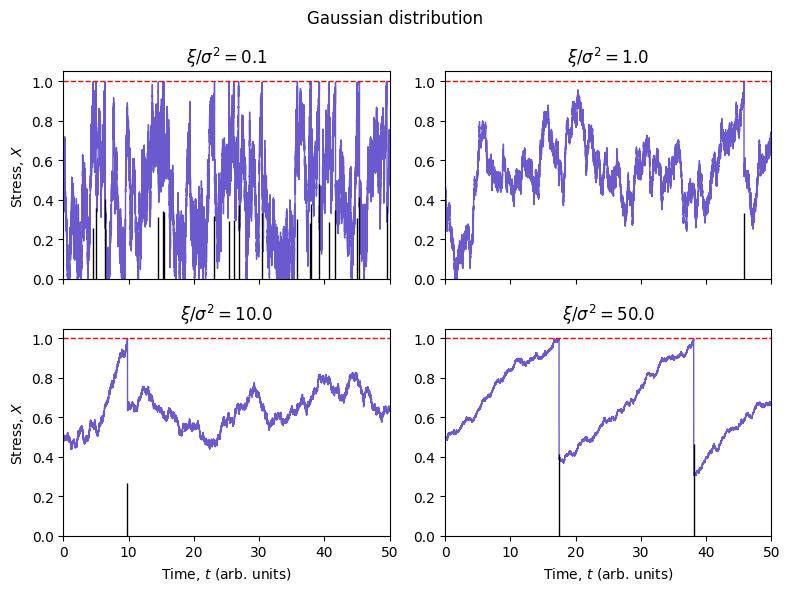

In [4]:
plot_brownian_glitch_panels(mu_list = [0.1, 1.0, 10.0, 50.0], 
                            xi = 0.025,
                            Xc = 1.0, 
                            dist_type='gaussian', 
                            dist_params={'mean': 0.5, 'std': 0.125},
                            x0=0.5, T=50, N=500_000,
                            title = 'Gaussian distribution')

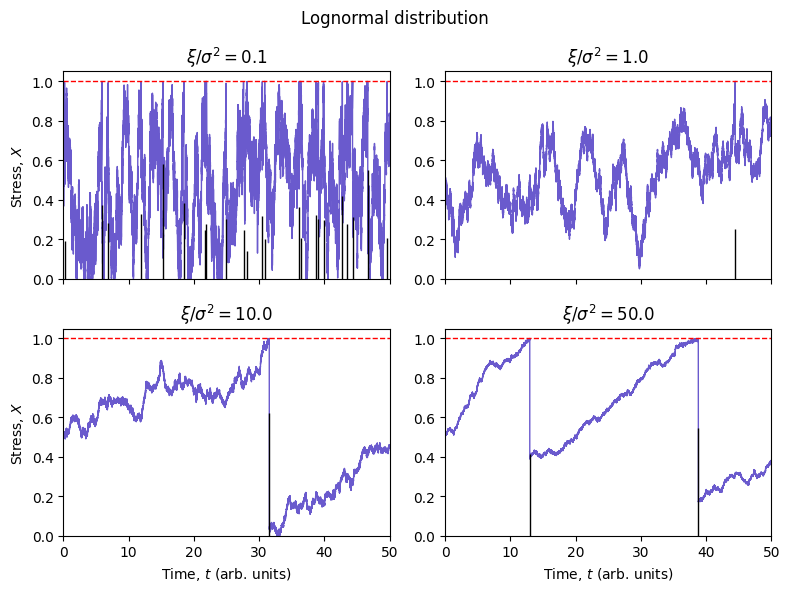

In [5]:
plot_brownian_glitch_panels(mu_list = [0.1, 1.0, 10.0, 50.0], 
                            xi = 0.025,
                            Xc = 1.0, 
                            dist_type='lognormal', 
                            dist_params={'mean': -1, 'std': 0.5},
                            x0=0.5, T=50, N=500_000,
                            title = 'Lognormal distribution')

### **Waiting time and size distributions**

The stress is not observable. Instead, what we observe are sequences of glitch sizes and waiting times.

The **conditional waiting time distribution**, $g(\Delta t \mid X_0)$, gives the probability density function (PDF) of waiting times $\Delta t$, when the inter-glitch evolution starts at $X_0$, according to (3). It is calculated as (Cox & Miller 1965):

$$
g(\Delta t \mid X_0) = -\frac{d}{d(\Delta t)} \left[ \int_{-\infty}^{X_c} p(X, \Delta t \mid X_0) \, dX \right].
\tag{6}
$$

The integral inside the square brackets, often called the **survivor function**, equals the probability density that the process stays in the interval $-\infty < X(t) \leq X_c$ for $0 \leq t \leq \Delta t$.

The starting stress $X_0$ is a random variable, related to the size of the previous glitch. To find the **observable waiting time distribution**, $p(\Delta t)$, we marginalize over the starting stress by calculating

$$
p(\Delta t) = \int_0^{X_c} dX_0 \, g(\Delta t \mid X_0) \, \eta(X_c - X_0),
\tag{7}
$$

where $\eta(\Delta X)$ equals the probability density of releasing an amount of stress $\Delta X = X_c - X_0$ during a glitch.

The conditional waiting time distribution, $g(\Delta t \mid X_0)$, is given by:

$$
g(\Delta t \mid X_0) = 2\mu \exp\left[\mu^2 \Delta t + \mu (X_1 - X_0)\right]
\sum_{n=1}^\infty \exp\left(-\lambda_n^2 \Delta t\right)
\frac{\lambda_n \sin[\lambda_n (X_1 - X_0)]}{\mu + \cos^2 \lambda_n}
\tag{8}
$$

where $\lambda_n$ is the $n$-th positive root of the transcendental equation

$$
\mu \tan \lambda_n = -\lambda_n,
\tag{9}
$$

and $X_1$ is the threshold stress (here, $X_1 = X_c$).

In this model, the glitch size $\Delta X$ is assumed to be proportional to the observed glitch size $\Delta\nu$, i.e., the increment in the pulsar's spin frequency:

$$
\Delta X = \frac{2\pi I_c}{I_s} \Delta\nu,
\tag{10}
$$

where $I_c$ and $I_s$ are the moments of inertia of the crust and superfluid interior, respectively.


### **Average waiting time**

The average waiting time, $\langle \Delta t \rangle$, is conditional on $X_0$. It can be calculated from $g(\Delta t \mid X_0)$ via

$$
\langle \Delta t \rangle = \int_0^\infty d(\Delta t)\, \Delta t\, g(\Delta t \mid X_0).
\tag{12}
$$

With the boundary conditions (4) and (5), we obtain (see Appendix A):

$$
\langle \Delta t \rangle = 2\mu\, \exp\left[\mu(1 - X_0)\right]
\sum_{n=1}^\infty \frac{\lambda_n \sin[\lambda_n (1 - X_0)]}{\left(\lambda_n^2 + \mu\right)^2 \left[\mu + \cos^2(\lambda_n)\right]}.
\tag{13}
$$

The behaviour of $\langle \Delta t \rangle$ as a function of $\mu$ is complicated, even after marginalizing over $X_0$. Numerical tests indicate that for $\mu \lesssim 1$, $\langle \Delta t \rangle$ is roughly constant with $\mu$, while for $\mu \gtrsim 1$ it varies inversely with $\mu$. The latter behaviour can be understood with the help of the approximate non-reflecting solution at large $\mu$ (see Appendix B), which has $\langle \Delta t \rangle \propto \mu^{-1}$, via equations (B1) and (12). The behaviour at low values of $\mu$ makes sense physically, as $\sigma$ dominates the time to reach the threshold $X_c$. On the other hand, at high values of $\mu$ and fixed $\sigma$, a high value of the effective coefficient $\xi$ leads the process to quickly reach $X_c$, while a low value of $\xi$ takes comparatively longer.

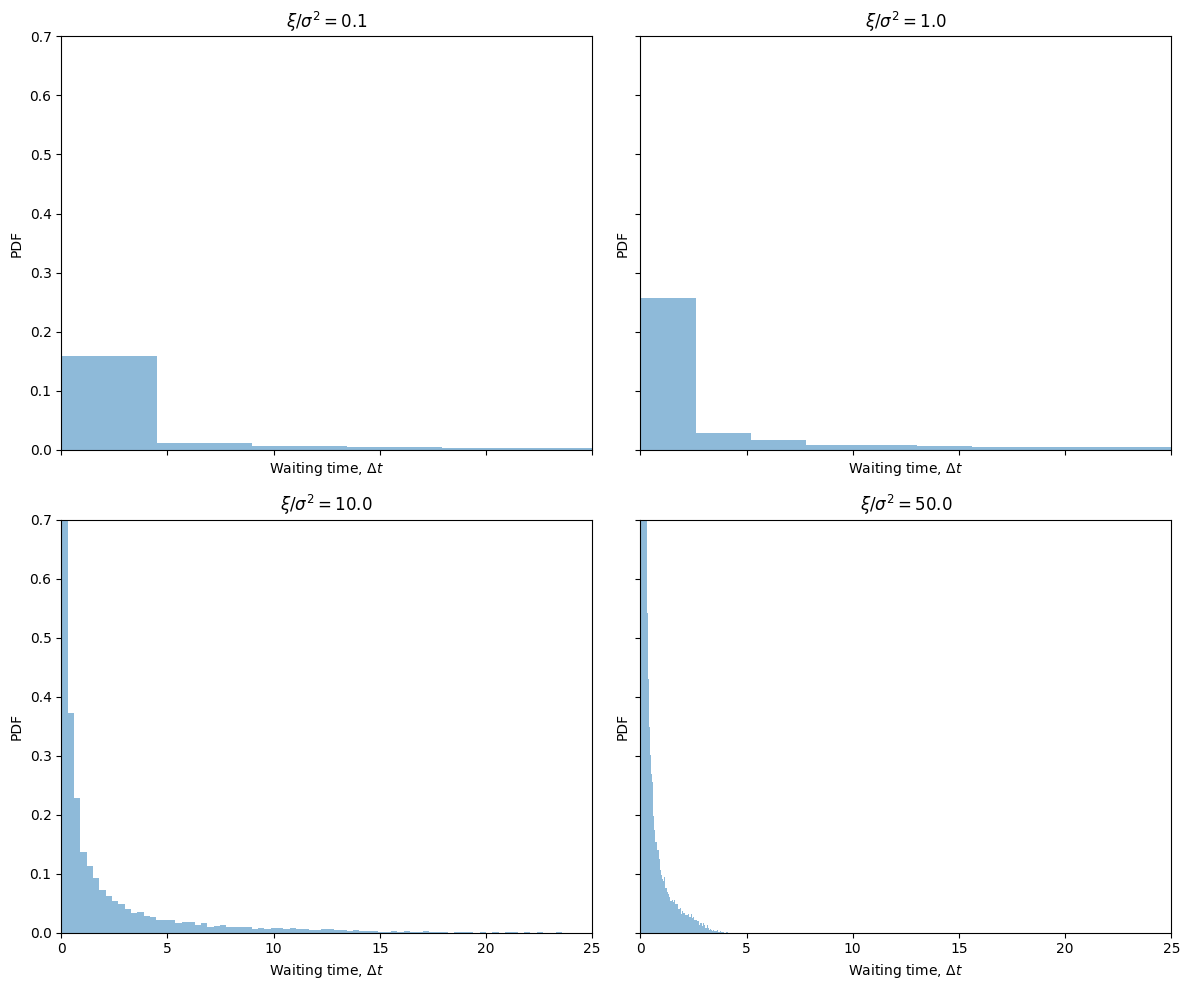

In [6]:
plot_waiting_time_histogram(mu_list = [0.1, 1.0, 10.0, 50.0],
                          Xc=1.0,
                          sigma = 0.08,
                          dist_type='neg_powerlaw',
                          dist_params={'delta': 1.5, 'beta': 0.01},
                          x0=0.5,
                          T=500,
                          N=100_000,
                          Nsim=50)

These plots confirm the theoretical predictions outlined above. Specifically, we observe that:

1. **Low drift regime ($\mu \lesssim 1$)**: The average waiting time $\langle \Delta t \rangle$ remains approximately constant with respect to $\mu$. In this regime, the diffusion term dominates the dynamics, and the random fluctuations control the time scale for reaching the threshold $X_c$.

2. **High drift regime ($\mu \gtrsim 1$)**: The average waiting time varies inversely with $\mu$, i.e., $\langle \Delta t \rangle \propto \mu^{-1}$. Here, the deterministic drift term dominates, and higher values of the effective coefficient $\xi$ lead to faster threshold crossing.

The transition between these two regimes occurs around $\mu \sim 1$, where the drift and diffusion contributions are comparable. This behavior is consistent with the analytical approximations derived in the appendices and demonstrates the model's ability to capture different physical regimes depending on the relative importance of deterministic versus stochastic driving forces.

### **Waiting time PDF**

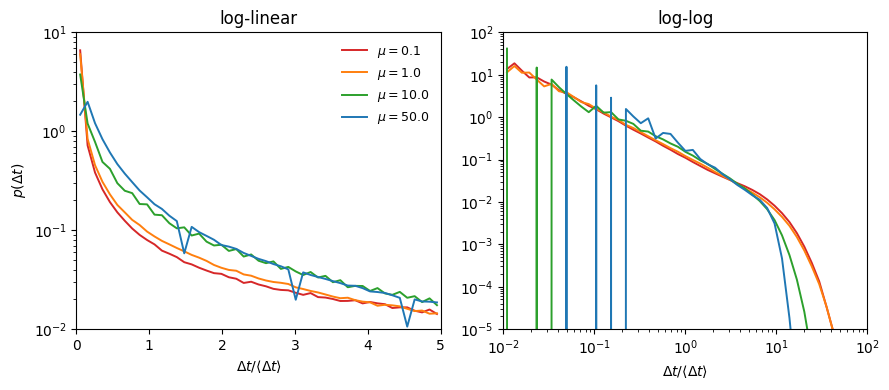

In [7]:
plot_waiting_time_distributions(mu_vals = [0.1, 1.0, 10.0, 50.0],
                                sigma = 0.15,
                                N_glitches = 1_000_000,
                                system_params={
                                    'dist_type': 'neg_powerlaw',
                                    'dist_params': {'delta': 1.5, 'beta': 1e-2}
                                },
                                sim_params={
                                    'x0': 0.5, 'Tsim': 500,
                                    'Nsteps': 100_000, 'Nsim': 500
                                })

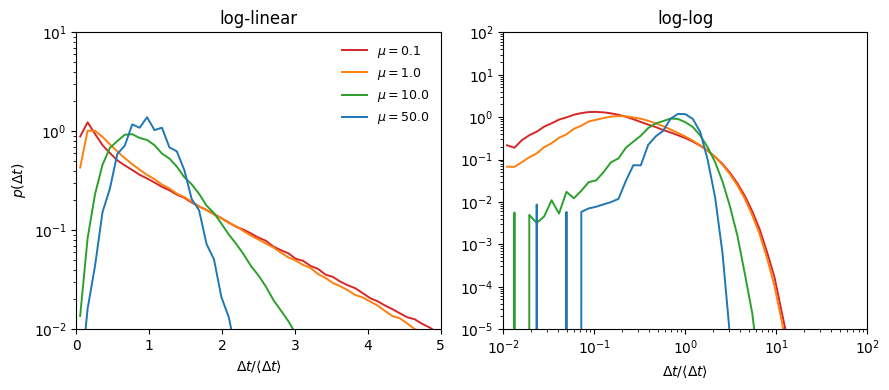

In [8]:
plot_waiting_time_distributions(mu_vals=[0.1, 1.0, 10.0, 50.0],
                                N_glitches=1_000_000,
                                system_params={
                                    'dist_type': 'gaussian',
                                    'dist_params': {'mean': 0.5, 'std': 0.125}
                                },
                                sim_params={
                                    'x0': 0.5, 'Tsim': 500,
                                    'Nsteps': 100_000, 'Nsim': 500
                                })

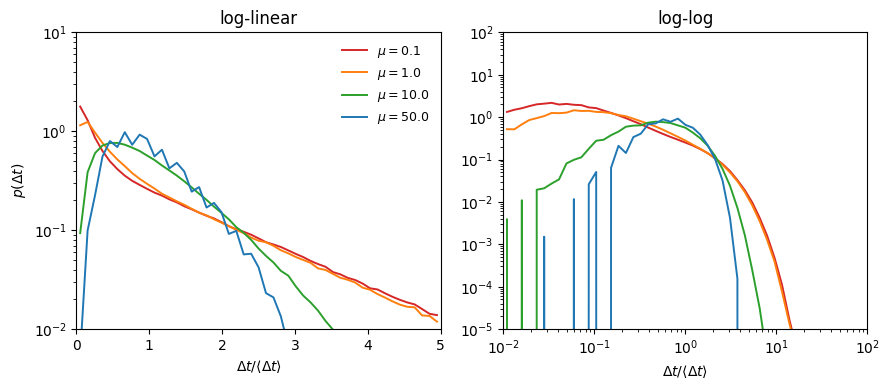

In [9]:
plot_waiting_time_distributions(mu_vals=[0.1, 1.0, 10.0, 50.0],
                                N_glitches=1_000_000,
                                system_params={
                                    'dist_type': 'lognormal',
                                    'dist_params': {'mean': -1, 'std': 0.5}
                                },
                                sim_params={
                                    'x0': 0.5, 'Tsim': 500,
                                    'Nsteps': 100_000, 'Nsim': 500
                                })

### **Comparison with the SDP meta-model**

A key goal of this paper is to create a framework for falsifying one or both of the Brownian and SDP meta-models by making quantitative predictions about long-term glitch statistics. As the two meta-models encompass a range of plausible microphysics, falsifying one or both has signiﬁcant scientiﬁc value in understanding which microphysical theories are consistent with the data.

The Brownian meta-model exhibits notable parallels with the SDP meta-model in their fundamental structure. Both frameworks connect observable variations in $ν(t)$ to an underlying, unobservable global stress parameter that oscillates near a state of marginal stability. Furthermore, both models represent instances of self-organized critical systems, though neither explicitly incorporates a detailed microphysical trigger mechanism in their formulation.

The meta-models also differ in important respects. The driver in the SDP meta-model is secular; it does not vary with time. In the Brownian meta-model, the driving torque is a fluctuating Langevin torque with white noise statistics, as in equation (1). The SDP process never quite reaches $X = X_c$, as glitches become increasingly likely for $X \to X_c$. In contrast, the Brownian meta-model reaches $X = X_c$ at every glitch.

Finally, $\eta(\Delta X)$ plays a different role in the two meta-models. One has $\Delta \nu \propto \Delta X$, so $\eta(\Delta X)$ and $p(\Delta \nu)$ have the same shape in the Brownian meta-model. In the SDP meta-model, $\eta(\Delta X)$ is conditional on $X(t)$ just before the glitch, so $\eta(\Delta X)$ and $p(\Delta \nu)$ have the same shape only under certain conditions.


In [ ]:
# TODO